In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [44]:
t_step = 0.001
return_offset = -60

f1 = 4
t1 = np.arange(0,1700)
f2 = 30
t2 = np.arange(0,1700)
f3 = 17
t3 = np.arange(1300,2500)
f4 = 30
t4 = np.arange(1300,2500)

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                   np.hstack([i*np.ones(50) for i in [1,2]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                   t_step,\
                   utils.create_decay(len(t1),1,400))
net2, F2_true, _ = utils.make_network(f2, len(t2), \
                   np.hstack([i*np.ones(50) for i in [1,2]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                   t_step,\
                   utils.create_decay(len(t2),1,400))
net3, F3_true, _ = utils.make_network(f3, len(t3), \
                   np.hstack([i*np.ones(50) for i in [2,1]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                   t_step,\
                   utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1200))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(10,-40,10)]]),\
                    t_step,\
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,4300+return_offset))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x[:,-len(t1):] += net1
x[:,-len(t2):] += net2
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) * t_step

Text(0, 0.5, 'Channel')

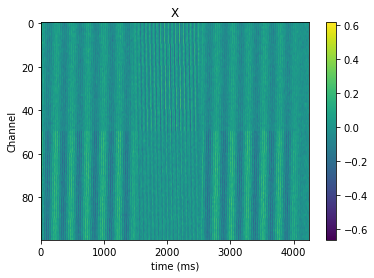

In [45]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.title('X')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

In [46]:
model = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.98)
model.fit_opt(x, t)

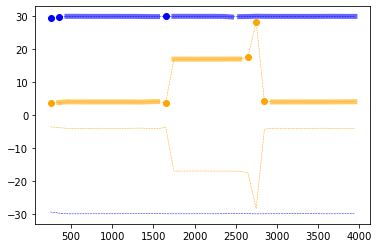

In [47]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange']
for i in range(len(group_idx)):
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])

In [48]:
model.fit_reduction(x, t)

Text(0, 0.5, 'Cosine Distance')

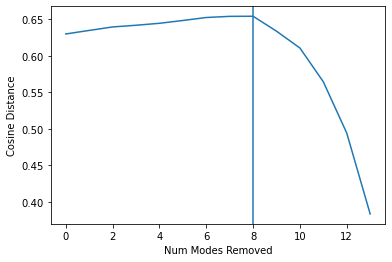

In [50]:
plt.plot(model.errors_)
plt.axvline(8)
plt.xlabel('Num Modes Removed')
plt.ylabel('Cosine Distance')

In [51]:
model.fit_f(x, t, t_step, 8)

/tmp/ipykernel_2890/422705195.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


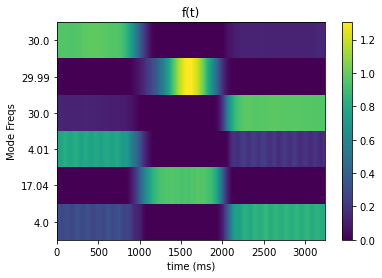

In [52]:
alpha = [str(np.round(f,2)) for f in model.freq_hat_]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(model.f_hat_[:,500:-500], aspect='auto')
fig.colorbar(cax)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
plt.title('f(t)')
plt.xlabel('time (ms)')
plt.ylabel('Mode Freqs')
plt.show()

In [53]:
x_rec = model.transform(x, t)

Text(0, 0.5, 'Channel')

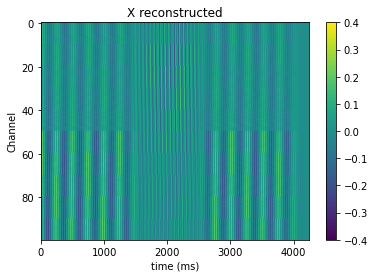

In [54]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

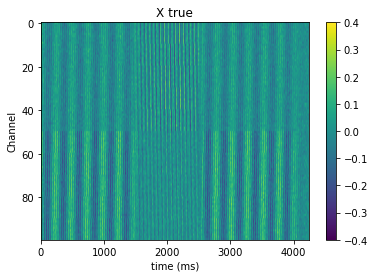

In [55]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')